# USPS Change of Address Data
### In, Out, Net migration

In [1]:
import pandas as pd
import numpy as np
import math
#import glob

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon
import geopandas as gpd

In [3]:
#pull in the 2018 to 2022 monthly zip code files
build = pd.DataFrame()

df = pd.DataFrame()
for y in range(2018,2024):
    build = pd.read_csv(f'../data/usps/Y{y}.csv')
    df = pd.concat([df,build])

In [4]:
df.head()

,YYYYMM,ZIPCODE,CITY,STATE,TOTAL FROM ZIP,TOTAL BUSINESS,TOTAL FAMILY,TOTAL INDIVIDUAL,TOTAL PERM,TOTAL TEMP,TOTAL TO ZIP,TOTAL BUSINESS.1,TOTAL FAMILY.1,TOTAL INDIVIDUAL.1,TOTAL PERM.1,TOTAL TEMP.1
0,201812,"=""00601""",ADJUNTAS,PR,0,0,0,0,0,0,15,0,0,12,13,0
1,201812,"=""00602""",AGUADA,PR,16,0,0,0,15,0,30,0,12,18,26,0
2,201812,"=""00603""",AGUADILLA,PR,20,0,0,13,15,0,45,0,14,30,34,11
3,201812,"=""00605""",AGUADILLA,PR,0,0,0,0,0,0,11,0,0,0,0,0
4,201812,"=""00610""",ANASCO,PR,0,0,0,0,0,0,28,0,0,19,17,11


In [5]:
#convert text zip column to int zips
df['zip'] = df.ZIPCODE.str[2:7]
df.zip = df.zip.astype(int)

#create a year column
df['year'] = df.YYYYMM.astype(str).str[:4]

In [6]:
#read in nyc zips, convert to list
zips = pd.read_csv('../data/geo/phx_zip-cousub.csv')
phx_zips = zips.zip.unique().tolist()

In [7]:
#table with NYC zips only
dff = df[df['zip'].isin(phx_zips)].copy()

In [8]:
#clean up & rename columns
dff.columns = ['YYYYMM','ZIPCODE','CITY','STATE',\
               'o_tot','o_bus','o_fam','o_ind','o_per','o_tem',\
               'i_tot','i_bus','i_fam','i_ind','i_per','i_tem',\
               'zip','year']

In [9]:
#calculate net change
cols = ['tot','bus','fam','ind','tem','per']
for col in cols:
    dff[f'n_{col}'] = dff[f'i_{col}'] - dff[f'o_{col}']

In [10]:
#drop extra stuff & reorder columns for zip id & date to be first
clean = dff[['zip','year','YYYYMM','o_tot','o_bus','o_fam','o_ind','o_per','o_tem',\
               'i_tot','i_bus','i_fam','i_ind','i_per','i_tem',\
            'n_tot','n_bus','n_fam','n_ind','n_per','n_tem']].copy()

In [11]:
clean.head()

,zip,year,YYYYMM,o_tot,o_bus,o_fam,o_ind,o_per,o_tem,i_tot,...,i_fam,i_ind,i_per,i_tem,n_tot,n_bus,n_fam,n_ind,n_per,n_tem
20059,85001,2018,201812,21,0,0,12,19,0,25,...,0,17,23,0,4,0,0,5,4,0
20060,85003,2018,201812,116,0,16,90,110,0,127,...,34,88,116,11,11,0,18,-2,6,11
20061,85004,2018,201812,150,15,26,109,138,12,168,...,17,131,152,16,18,5,-9,22,14,4
20062,85005,2018,201812,0,0,0,0,0,0,36,...,21,14,35,0,36,0,21,14,35,0
20063,85006,2018,201812,205,0,42,158,194,11,182,...,33,146,168,14,-23,0,-9,-12,-26,3


##### make lists for the in, out, and net mig columns to build separate tables

In [12]:
n_cols,i_cols,o_cols = cols,cols,cols
col_list = [n_cols,i_cols,o_cols]

n_cols = ['n_' + sub for sub in n_cols]
i_cols = ['i_' + sub for sub in i_cols]
o_cols = ['o_' + sub for sub in o_cols]

#### pivot for net, in, and out

In [13]:
net = pd.pivot_table(clean,values=n_cols,index='zip',
                            columns='YYYYMM',aggfunc=np.sum,fill_value=0,margins=True).reset_index()

In [14]:
in_mig = pd.pivot_table(clean,values=i_cols,index='zip',
                            columns='YYYYMM',aggfunc=np.sum,fill_value=0,margins=True).reset_index()

In [15]:
out_mig = pd.pivot_table(clean,values=o_cols,index='zip',
                            columns='YYYYMM',aggfunc=np.sum,fill_value=0,margins=True).reset_index()

with pd.ExcelWriter(f'output/usps_in-out-net.xlsx') as writer:
    net.to_excel(writer, sheet_name="net")
    in_mig.to_excel(writer, sheet_name="in")
    out_mig.to_excel(writer, sheet_name="out")

# visualization

In [79]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon
import geopandas as gpd
from geopandas import GeoDataFrame

In [17]:
# allow max rows and colums to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [63]:
df_map = clean[['zip','year','n_tot','n_per','n_tem',\
                'o_tot','o_per','o_tem','i_tot','i_per','i_tem']]

df_map = df_map[df_map['year']!='2018'].copy()

df_map = df_map.groupby(['zip','year']).sum().reset_index()

In [64]:
geo = gpd.read_file('../data/geo/shapefiles/Phoenix_ZCTA.shp')
geo['joinid'] = geo['GEOID20'].astype(int)
#geo.head(2)

In [65]:
geo = geo[['joinid','geometry']]

In [66]:
netdf = df_map[['zip','year','n_tot']].copy()
indf = df_map[['zip','year','i_tot']].copy()
outdf = df_map[['zip','year','o_tot']].copy()

In [48]:
netdf.n_tot.describe()

count     310.000000
mean     -111.367742
std       393.298655
min     -1322.000000
25%      -345.000000
50%        -2.000000
75%        99.500000
max       942.000000
Name: n_tot, dtype: float64

In [49]:
indf.i_tot.describe()

count     310.000000
mean     2297.454839
std      2315.403868
min         0.000000
25%       273.750000
50%      1524.000000
75%      4212.750000
max      8502.000000
Name: i_tot, dtype: float64

In [50]:
outdf.o_tot.describe()

count     310.000000
mean     2408.822581
std      2512.947581
min         0.000000
25%       206.000000
50%      1550.000000
75%      4437.000000
max      9069.000000
Name: o_tot, dtype: float64

In [73]:
years = ['2019','2020','2021','2022']

In [67]:
netdf = pd.merge(netdf,geo,how='left',left_on='zip',right_on='joinid')

In [68]:
netdf = netdf.dropna().drop(columns=['joinid'])

In [76]:
test.head()

,zip,year,n_tot,geometry
7,85003,2020,-174,"POLYGON ((-112.08299 33.47943, -112.08041 33.4..."
12,85004,2020,-342,"POLYGON ((-112.07586 33.46761, -112.07586 33.4..."
22,85006,2020,-552,"POLYGON ((-112.06623 33.45761, -112.06623 33.4..."
27,85007,2020,0,"POLYGON ((-112.10010 33.45514, -112.10008 33.4..."
32,85008,2020,-1187,"POLYGON ((-112.03145 33.47476, -112.03111 33.4..."


Text(0.5, 1.0, 'Net Migration 2020')

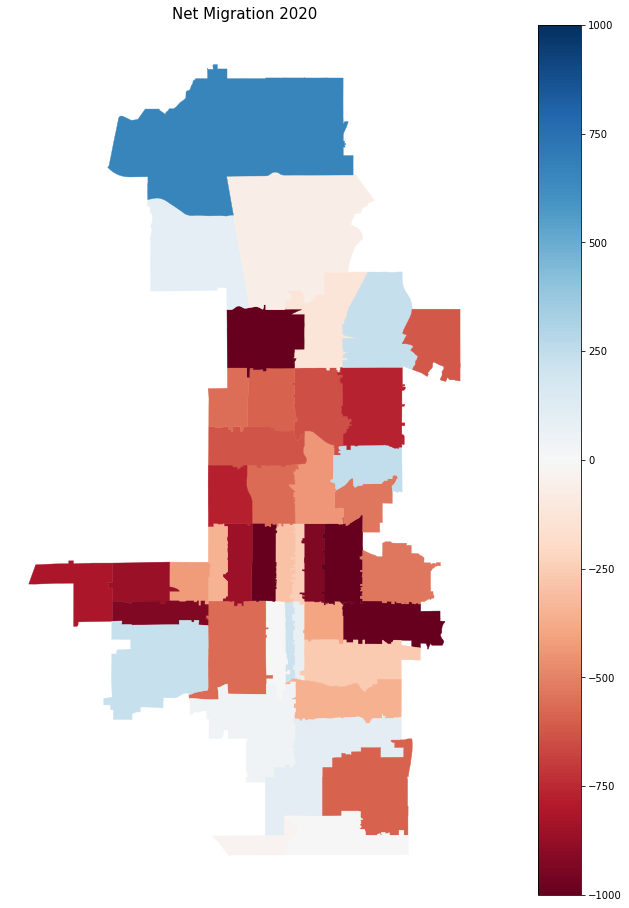

In [85]:
test = netdf[netdf.year=='2022']
test = GeoDataFrame(test)

fig, ax = plt.subplots(1, figsize = (20,16))
ax.axis('off')
divnorm = mpl.colors.TwoSlopeNorm(vmin= -1000, vcenter = 0,vmax = 1000)
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=divnorm)
sm.set_array([])
test.plot(column = 'n_tot', cmap = 'RdBu', edgecolor="face", norm = divnorm, linewidth=0.4, ax = ax)
fig.colorbar(sm)
ax.set_title(f'Net Migration 2020', color = 'k',  fontsize = 15)

In [72]:
def net_maps(gdf,year):
    fig, ax = plt.subplots(1, figsize = (20,16))
    ax.axis('off')
    divnorm = mpl.colors.TwoSlopeNorm(vmin= -1000, vcenter = 0,vmax = 1000)
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=divnorm)
    sm.set_array([])
    gdf.plot(column = 'n_tot', cmap = 'RdBu', edgecolor="face", norm = divnorm, linewidth=0.4, ax = ax)
    fig.colorbar(sm)
    ax.set_title(f'Net Migration {year}', color = 'k',  fontsize = 15)
    #plt.savefig(f'../viz/net_{year}.jpg', dpi = 300) # saving each year

AttributeError: 'Line2D' object has no property 'column'

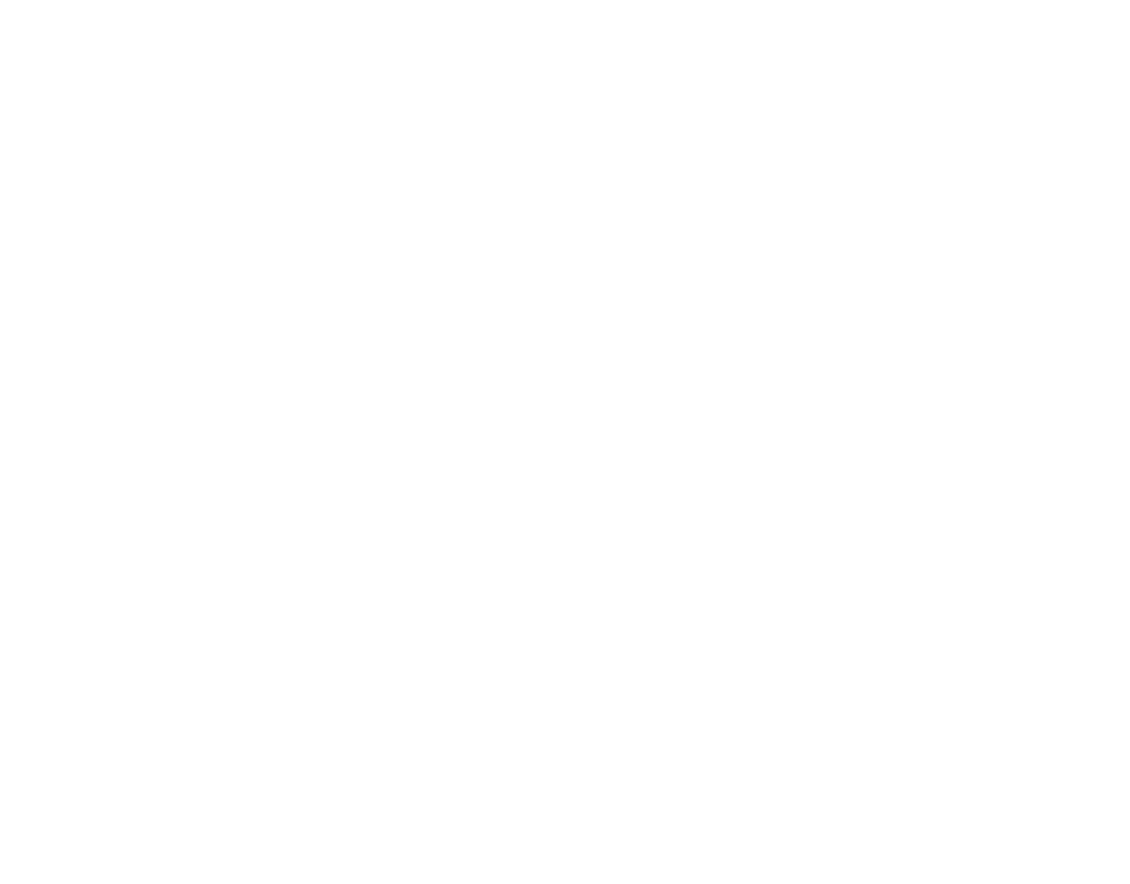

In [74]:
for y in years:
    gdf = netdf[netdf.year==y]
    net_maps(gdf,y)